### Imports

In [1]:
import importlib
import traceback
import os
import h5py
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

import findatree.io as io
import findatree.photometric as photometric
import findatree.transformations as transformations

_ = importlib.reload(io)
_ = importlib.reload(photometric)
_ = importlib.reload(transformations)

plt.style.use(r'C:\Repos\findatree\own.mplstyle')

### Definitions

In [2]:
# Define directory where to load pre-processed tnr hdf5s
dir_name_hdf5 = r"C:\Data\lwf\processed\2020\hdf5"

# Define directory where to save intermediate px information of crowns
dir_name_hdf5_save = r"C:\Data\lwf\analysis\px-wise_correlation\hdf5"

# Define directory where to save plots
dir_name_plots_save = r"C:\Data\lwf\analysis\px-wise_correlation\plots"

# Vegetation indices used in px-wise correlation
channel_names = ['ndvi', 'ndvire', 'ndre', 'grvi', 'chm', 'light']

# Collect pixel wise correlation of ... 
# ... n random tnrs or
n_tnrs_random = 0

# ... specific tnrs
tnrs_specific = [
    # 15519,
]

### Processing

#### Prepare main loop
* Either inlcude n random tnrs ...
* or include specific tnrs

In [97]:
# Get all available tnr numbers in directory
tnrs = io.find_all_tnrs_in_dir(dir_name_hdf5, tnr_pattern_lead='tnr', tnr_pattern_trail='.hdf5')

# Define full paths to all pre-processed tnr hdf5s
paths = [os.path.join(dir_name_hdf5, f"tnr{tnr}.hdf5") for tnr in tnrs]


# Include only specified tnrs in main loop
if len(tnrs_specific) > 0:
    tnrs_keep_idx = tnrs.index(tnrs_specific)
    
    try:
        paths_keep = [paths[idx] for idx in tnrs_keep_idx]
    except:
        paths_keep = [paths[tnrs_keep_idx]]

    print('Following files will be included in main loop:')
    for p in paths_keep: print(' '*3, p)

elif n_tnrs_random > 0:
    tnrs_keep_idx = np.random.randint(0, len(tnrs), n_tnrs_random)
    tnrs_keep = [tnrs[i] for i in tnrs_keep_idx]

    try:
        paths_keep = [paths[idx] for idx in tnrs_keep_idx]
    except:
        paths_keep = [paths[tnrs_keep_idx]]

    print('Following files will be included in main loop:')
    for p in paths_keep: print(' '*3, p)

else:
    tnrs_keep = tnrs.copy()
    paths_keep = paths.copy()

#### Run main loop
* Load channels and crowns
* Filter crowns features according to `kkl, eccentricity and equivalent_diameter_area`
* Filter polygons
* Convert filtered polygons to label_image/mask
* Assign vegetation index values of all pixels in mask

In [98]:
exception_traceback = []

vi = np.zeros((0, len(channel_names) + 2), dtype = np.float32)

for tnr, path in tqdm(zip(tnrs_keep,paths_keep)):
    
    try:
        
        ################# [1] Load channels and crowns group from hdf5
        data, params_data = io.load_hdf5(path, groups = ['channels', 'crowns_human'])

        # Channels
        channels, params_channels = data['channels'].copy(), params_data['channels'].copy()
        transformations.channels_extend(channels)
        
        # Crowns
        crowns_human, params_crowns_human = data['crowns_human'].copy(), params_data['crowns_human'].copy()
        
        del data, params_data

        ################# [2] Filter crowns features
        # Get combined features
        features = pd.merge(
            left = pd.DataFrame(crowns_human['features']['terrestrial']),
            right = pd.DataFrame(crowns_human['features']['photometric']),
            on = ['id'],
            how = 'inner',
        )

        # Define query
        query_str = 'kkl in [1,2,3]'
        query_str += ' and eccentricity > 0'
        query_str += ' and eccentricity < 1'
        query_str += ' and equivalent_diameter_area > 1'
        
        # These are the valid ids
        ids = features.query(query_str)['id'].values

        ################# [3] Filter polygons
        polys = {}
        for id in ids:
            polys[id] = crowns_human['polygons'][id].copy()

        ################# [4] Convert filtered polygons to label_image/mask
        label_image = transformations.polygons_to_labelimage(
            polys,
            params_crowns_human['shape'],
        )
        mask = label_image.copy()
        mask[mask > 0] = 1
        mask = mask.astype(np.bool_)

        ################# [5] Assign vegetation index values of all pixels in mask to vi array
        
        # Init current array that holds vegetation indices, plus id and tnr
        vi_current = np.zeros((np.sum(mask), len(channel_names) + 2), dtype = np.float32)
        
        # Assign channels in-mask pixels to current array
        for i, name in enumerate(channel_names):
            vi_current[:, i] = channels[name][mask]
        
        vi_current[:, -2] = tnr
        vi_current[:, -1] = label_image[mask]

        # Concatenate current array to array of all tnrs
        vi = np.concatenate([vi, vi_current], axis=0)

    except:
            exception_traceback.append({
                'path': path,
                'traceback': traceback.format_exc(),
                })

print()
print('Done!')
print(f"{len(exception_traceback)} exceptions occured")

128it [01:16,  1.66it/s]


Done!
2 exceptions occured


#### Print exceptions

In [81]:
for e in exception_traceback:
    print(e['path'])
    print('-->', e['traceback'])

C:\Data\lwf\processed\2020\hdf5\tnr11581.hdf5
--> Traceback (most recent call last):
  File "C:\Users\flori\AppData\Local\Temp\ipykernel_10336\3001015221.py", line 17, in <cell line: 5>
    crowns_human, params_crowns_human = data['crowns_human'].copy(), params_data['crowns_human'].copy()
KeyError: 'crowns_human'

C:\Data\lwf\processed\2020\hdf5\tnr11601.hdf5
--> Traceback (most recent call last):
  File "C:\Users\flori\AppData\Local\Temp\ipykernel_10336\3001015221.py", line 25, in <cell line: 5>
    right = pd.DataFrame(crowns_human['features']['photometric']),
KeyError: 'photometric'



#### Save intermediate result in hdf5


In [99]:
names = channel_names + ['tnr', 'id']
dtype = np.dtype([(name, 'f4') if name not in ['tnr', 'id'] else (name, 'u4') for name in names])

# Prepare results as structurd array
data = np.lib.recfunctions.unstructured_to_structured(
    vi,
    dtype=dtype,
)

# Prepare parameters
params = {}
params['channel_names'] = names
params['n_tnrs'] = len(tnrs_keep)
params['tnrs_keep'] = tnrs_keep
params['n_px'] = data.shape[0]

file_name_save = 'tnr_all.hdf5'

with h5py.File(os.path.join(dir_name_hdf5_save, file_name_save), 'w') as f:
    dset = f.create_dataset(name='data', data=data)
    for key, val in params.items():
        dset.attrs[key] = val

df = pd.DataFrame(data)

#### Load intermediate results

In [3]:
file_name_load = 'tnr_all.hdf5'

with h5py.File(os.path.join(dir_name_hdf5_save, file_name_load), 'r') as f:
    dset = f.get('data')
    data = np.array(dset, dset.dtype)

    params = {}
    for key, val in dset.attrs.items():
        params[key] = val

df = pd.DataFrame(data)

# df = df.query('ndre > 0')

### Plotting

#### 2D correlation histogram: Definition

In [5]:
def plotter(
    df,
    bins,
    x_name,
    y_name,
    x_range,
    y_range,
    z_range,
):

    x = df.loc[:, x_name].values
    y = df.loc[:, y_name].values

    x_mean, y_mean = np.nanmean(x), np.nanmean(y)

    H, xedges, yedges = np.histogram2d(
        x,
        y,
        bins = [bins, bins],
        range = [x_range, y_range],
    )

    with np.errstate(divide='ignore', invalid='ignore'):
        H = np.log10(H.T)

    f = plt.figure(1, figsize=[3,3])
    f.clear()
    ax = f.add_subplot()

    mapp = plt.imshow(
        H,
        interpolation='nearest',
        origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        vmin=np.log10(z_range[0]),
        vmax=np.log10(z_range[1]),
        aspect=(x_range[1] - x_range[0]) / (y_range[1] - y_range[0]),
        )
    plt.colorbar(
        mapp,
        ax=ax,
        shrink=0.8,
        format=r'$10^{%i}$',
        label='Occurences'
        )
    ax.plot(
        [xedges[0], xedges[-1]],
        [yedges[0], yedges[-1]],
        '--',
        c='k',
        lw=1,
    )
    ax.axhline(0, ls='--', c='k', lw=1)
    ax.axvline(0, ls='--', c='k', lw=1)
    
    ax.scatter(
        x_mean,
        y_mean,
        s=15,
        marker='o',
        ec='k',
        fc='w',
        lw=0.7,
    )

    _ = ax.set_xlabel(x_name.upper())
    _ = ax.set_xlim(xedges[0],xedges[1])
    _ = ax.set_xticks(np.linspace(xedges[0],xedges[-1],5))

    _ = ax.set_ylabel(y_name.upper())
    _ = ax.set_ylim(yedges[0],yedges[1])
    _ = ax.set_yticks(np.linspace(yedges[0],yedges[-1],5))

    return f

#### 2D histogram correlation: Plotting

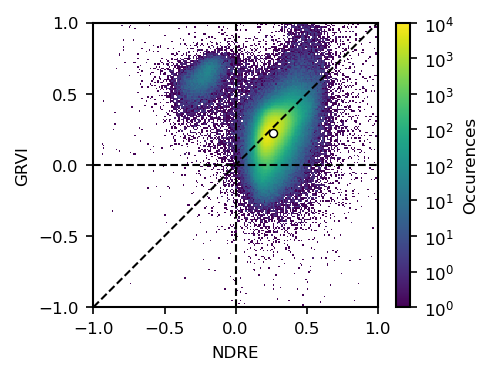

In [6]:
names = ['ndvi','ndvire','ndre','grvi']
ranges = [[-1,1] for name in names]
bins = 200
z_range = [1e0, 1e4]

for x_i, x_name in enumerate(names):
    for y_i, y_name in enumerate(names):
        if x_i < y_i:
            f = plotter(
                df,
                bins,
                x_name,
                y_name,
                ranges[x_i],
                ranges[y_i],
                z_range,
            )
            plt.savefig(os.path.join(dir_name_plots_save, f"{x_name}_{y_name}.svg"), transparent=True)


#### Spearman's rank correlation and Pearson's correlation: Computation

In [161]:

names_corr = ['ndvi', 'ndvire', 'ndre', 'grvi']
n_samples_corr = 50000

data_corr = df.loc[:, names_corr].values
data_corr = data_corr[np.random.randint(0,len(df), n_samples_corr),:]

spear_corr, spear_pvalue = scipy.stats.spearmanr(data_corr, nan_policy='omit')

pears_corr = np.zeros((len(names_corr), len(names_corr)))
pears_pvalue = np.zeros((len(names_corr), len(names_corr)))

for row in range(0, len(names)):
    for col in range(0, len(names)):
        x = data_corr[:, row]
        y = data_corr[: , col]
        finite_idx = np.isfinite(x) & np.isfinite(y)
        x = x[finite_idx]
        y = y[finite_idx]

        pears_corr[row,col], pears_pvalue[row,col] = scipy.stats.pearsonr(x, y)

#### Spearman's rank correlation: Plotting

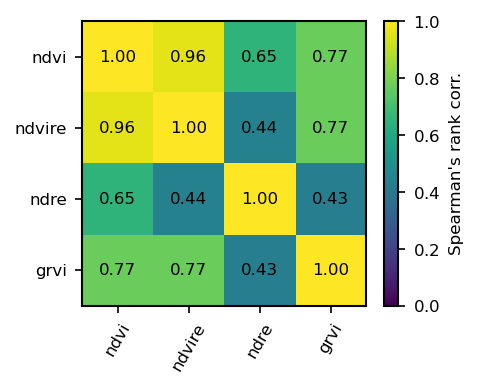

In [162]:
f = plt.figure(1, figsize=[3,3])
ax = f.add_subplot()

mapp = plt.imshow(
    spear_corr,
    interpolation='nearest',
    origin='upper',
    vmin=0,
    vmax=1,
    )
plt.colorbar(
    mapp,
    ax=ax,
    shrink=0.8,
    format=r'$%.1f$',
    label="Spearman's rank corr."
    )

for row in range(0,spear_corr.shape[0]):
    for col in range(0,spear_corr.shape[1]):
        ax.text(
            col,
            row,
            f"{spear_corr[row,col]:.2f}",
            horizontalalignment='center',
            verticalalignment='center',
            )

_ = ax.set_xticks(range(0,len(names_corr)))
_ = ax.set_xticklabels(names_corr, rotation=60)
_ = ax.set_yticks(range(0,len(names_corr)))
_ = ax.set_yticklabels(names_corr)

plt.savefig(os.path.join(dir_name_plots_save, f"spearmans.svg"), transparent=True)

#### Persons's correlation: Plotting

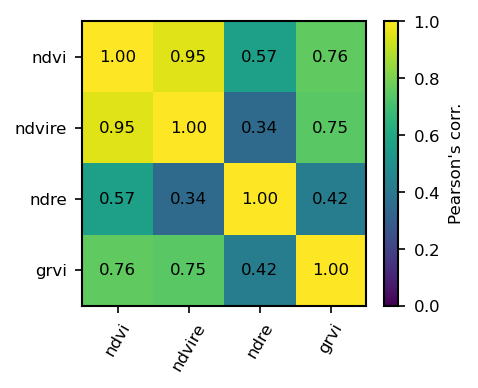

In [163]:
f = plt.figure(1, figsize=[3,3])
ax = f.add_subplot()

mapp = plt.imshow(
    pears_corr,
    interpolation='nearest',
    origin='upper',
    vmin=0,
    vmax=1,
    )
plt.colorbar(
    mapp,
    ax=ax,
    shrink=0.8,
    format=r'$%.1f$',
    label="Pearson's corr."
    )

for row in range(0,spear_corr.shape[0]):
    for col in range(0,spear_corr.shape[1]):
        ax.text(
            col,
            row,
            f"{pears_corr[row,col]:.2f}",
            horizontalalignment='center',
            verticalalignment='center',
            )

_ = ax.set_xticks(range(0,len(names_corr)))
_ = ax.set_xticklabels(names_corr, rotation=60)
_ = ax.set_yticks(range(0,len(names_corr)))
_ = ax.set_yticklabels(names_corr)

plt.savefig(os.path.join(dir_name_plots_save, f"pearsons.svg"), transparent=True)